![header](https://i.imgur.com/I4ake6d.jpg)

# IN SITU BLACK SEA TRAINING

<div style="text-align: right"><i> 13-05-Part-five-out-of-five </i></div>

# BS `NRT` product/dataset: managing files (thermosal)

<h1>Table of Contents<span class="tocSkip"></h1>
<div class="toc">
    <ul class="toc-item">
        <li><span><a href="#Introduction" data-toc-modified-id="Introduction">Introduction</a></span></li>
        <li>
            <span><a href="#Setup" data-toc-modified-id="Setup">Setup</a></span>
            <ul>
                <li><span><a href="#Python-packages" data-toc-modified-id="Python-packages">Python packages</a></span></li>
            </ul>
        </li>
        <li><span><a href="#Thermosal-(TS)-data" data-toc-modified-id="Thermosal-(TS)-data">Thermosal (TS) data</a></span>
            <ul>
                <li><span><a href="#Trajectory-animation" data-toc-modified-id="Trajectory-animation">Trajectory-animation</a></span></li>
                <li><span><a href="#Along-track-variable-evolution" data-toc-modified-id="Along-track-variable-evolution">Along track variable evolution</a></span></li>
        <li><span><a href="#Overall-variable-evolution" data-toc-modified-id="Overall-variable-evolution">Overall variable evolution</a></span></li>
            </ul>
        </li>
        <li><span><a href="#Wrap-up" data-toc-modified-id="Wrap-up">Wrap-up</a></span></li>
        <li><span><a href="#Feedback-survey" data-toc-modified-id="Feedback-survey">Feedback survey</a></span></li>
    </ul>
</div>

## Introduction

According to the [13-01-NearRealTtime-product-collections-overview.ipynb](13-01-NearRealTtime-product-collections-overview.ipynb) one of the less common data source types available are the Thermosal. Please use the notebook [13-02-NearRealTtime-product-subsetting-download](13-02-NearRealTtime-product-subsetting-download.ipynb) to download some files from Thermosal ('TS' data type) and let's check its data. <br> If you wanna skip the downloading part you can use the netCDF files available <a href="data" target="_blank">here</a> instead.    

## Setup

### Python packages

For the notebook to properly run we need to first load the next packages available from the Jupyter Notebook Ecosystem. Please run the `next cell`:

In [304]:
import warnings
warnings.filterwarnings("ignore")

import os
import pandas as pd
import IPython
import datetime
import numpy as np
import xarray
import folium
from folium import plugins
import branca
%matplotlib inline

<div class="alert alert-block alert-warning">
<b>WARNING</b>
    
***  
If any of them raises any error it means you need to install the module first. For doing so please:
1. Open a new cell int he notebook
2. Run <i>`!conda install packageName --yes`</i> or <i>`!conda install -c conda-forge packageName --yes`</i> or <i>`!pip install packageName`</i>
3. Import again!
<br><br>
Example: <i>how-to-solve import error for json2html module </i>

![region.png](img/errorImporting.gif)

## Thermosal (TS) data

Thermosalor Thermosalinographs are devices on board of vessels that measure watter intakes (i.e temperature, conductivity etc) as it moves. The resulting data feature is a trajectory-like time serie.

Let's see the data of one of the available thermosal in the BS.<br>`Run the next cell` to see the thermosal files already available in the /data folder:

In [305]:
IPython.display.IFrame('http://localhost:8888/tree/data/files/TS', width='100%', height=350)

### Reading the file

`Set one` of the above available `file name` and `run the next cells`:

In [454]:
file = 'BS_TS_TS_2IYG2_2019.nc'
path = os.path.join(os.path.join(os.getcwd(), 'data', 'files','TS'), file)

In [422]:
ds = xarray.open_dataset(path)
ds.close()
ds

<xarray.Dataset>
Dimensions:      (DEPTH: 1, LATITUDE: 20, LONGITUDE: 20, POSITION: 20, TIME: 20)
Coordinates:
  * TIME         (TIME) datetime64[ns] 2019-01-02T12:00:00 ... 2019-03-19T06:00:00
  * LATITUDE     (LATITUDE) float32 40.7 40.7 40.7 40.7 ... 42.2 41.6 41.4 40.8
  * LONGITUDE    (LONGITUDE) float32 29.6 29.6 29.6 29.6 ... 30.8 29.4 29.1 28.4
Dimensions without coordinates: DEPTH, POSITION
Data variables:
    TIME_QC      (TIME) float32 ...
    POSITION_QC  (POSITION) float32 ...
    DEPH         (TIME, DEPTH) float32 ...
    DEPH_QC      (TIME, DEPTH) float32 ...
    TEMP         (TIME, DEPTH) float64 ...
    TEMP_QC      (TIME, DEPTH) float32 ...
    VGHS         (TIME, DEPTH) float64 ...
    VGHS_QC      (TIME, DEPTH) float32 ...
    VGTA         (TIME, DEPTH) float64 ...
    VGTA_QC      (TIME, DEPTH) float32 ...
    DRYT         (TIME, DEPTH) float64 ...
    DRYT_QC      (TIME, DEPTH) float32 ...
    WSPD         (TIME, DEPTH) float64 ...
    WSPD_QC      (TIME, DEPTH) f

The above one is an overview of the content of the file: variables, dimensions, coordinates, global attributes...
<br>Let's list now the available variables: `run the next cell`

In [423]:
for var in ds.variables:
    print(var + ':' + ds[var].attrs['long_name'])

TIME:Time
TIME_QC:quality flag
LATITUDE:Latitude of each location
LONGITUDE:Longitude of each location
POSITION_QC:quality flag
DEPH:Depth
DEPH_QC:quality flag
TEMP:Sea temperature
TEMP_QC:quality flag
VGHS:Generic significant wave height (Hs)
VGHS_QC:quality flag
VGTA:Generic average wave period
VGTA_QC:quality flag
DRYT:Air temperature in dry bulb
DRYT_QC:quality flag
WSPD:Horizontal wind speed
WSPD_QC:quality flag


Let's see the average sampling rate:

In [424]:
start = datetime.datetime.strptime(ds.attrs['time_coverage_start'], '%Y-%m-%dT%H:%M:%SZ')
end = datetime.datetime.strptime(ds.attrs['time_coverage_end'], '%Y-%m-%dT%H:%M:%SZ')

In [425]:
aprox_sampling_rate_in_minutes = ((end-start).total_seconds()/60)/len(ds['TIME'])
'one measure every '+str(aprox_sampling_rate_in_minutes)+' minutes'

'one measure every 5454.0 minutes'

The sampling rate is to bare in mind when plotting as it might be quite time consumming. We will see later an example.

### Data visualization

#### Trajectory animation

As stated before, the thermosal is on board of a mobile platform (a vessel).
<br>Let's check the overall trajectory by joining the sampling points.

In In Situ TAC netCDFs all variables are linked to another called the same plus '_QC'. This 'twin' variable contains a quality flag for each value in the paired variable.`run the next cell` to check the flag values convention:

In [442]:
pd.DataFrame(data=ds['TEMP_QC'].attrs['flag_values'],
             index=ds['TEMP_QC'].attrs['flag_meanings'].split(' '), columns=['quality flag'])

,quality flag
no_qc_performed,0
good_data,1
probably_good_data,2
bad_data_that_are_potentially_correctable,3
bad_data,4
value_changed,5
not_used,6
nominal_value,7
interpolated_value,8
missing_value,9


Users are recommended to use only the data flagged as 1, they so called 'good data'. Let's then check the available flags for the coordinates (time and position) to see if we need to get rid of not-good values: `run the next cells`

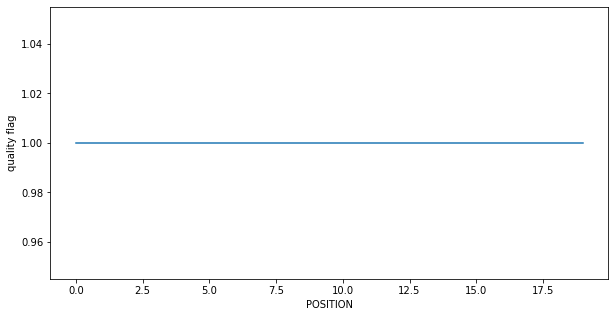

In [443]:
ds['POSITION_QC'].plot(aspect=2, size=5)

From above, we see that there are no QC flags values different from 1, meaning we are ready to go!(`run the next cell`):

In [444]:
lats = ds['LATITUDE'].values.tolist()
lons = ds['LONGITUDE'].values.tolist()
times = ds['TIME'].astype(str).values.tolist()

Let's create now a geojson feature representing the vessel:

In [445]:
vessel = {
    'type': 'Feature',
    'geometry': {
        'type': 'LineString',
        'coordinates': []
    },
    'properties': {
        'times': [],
    }
}

Let's populate it:

In [446]:
for time, lat, lon in zip(times, lats, lons):
    base = [lat,lon]
    if(any(x is None for x in base)):
        continue
    if(any(np.isnan(x) for x in base)):
        continue
    vessel['properties']['times'].append(time[:19])
    vessel['geometry']['coordinates'].append([lon, lat])

In [447]:
mean_lat, mean_lon = np.nanmean(lats), np.nanmean(lons)
m = folium.Map(location=[mean_lat, mean_lon], zoom_start=6)
marker = plugins.TimestampedGeoJson({
    'type': 'FeatureCollection',
    'features': [vessel],
}, add_last_point=True, loop=False).add_to(m)
m

<div class="alert alert-block alert-warning">
<b>WARNING</b>
    
***  
If you do not see any map when running the next cell please change your navigator (try chrome!).

### Along track variable evolution

Let's focus on one of the variables to visualize its data!: `set one and run the next cell`

In [450]:
param = 'TEMP'
ds[param]

<xarray.DataArray 'TEMP' (TIME: 20, DEPTH: 1)>
array([[8.299],
       [9.799],
       [8.099],
       [8.399],
       [8.199],
       [8.599],
       [9.199],
       [8.799],
       [8.399],
       [7.199],
       [6.999],
       [6.899],
       [7.099],
       [7.699],
       [7.199],
       [7.299],
       [7.399],
       [7.799],
       [8.299],
       [8.599]])
Coordinates:
  * TIME     (TIME) datetime64[ns] 2019-01-02T12:00:00 ... 2019-03-19T06:00:00
Dimensions without coordinates: DEPTH
Attributes:
    long_name:      Sea temperature
    standard_name:  sea_water_temperature
    units:          degrees_C

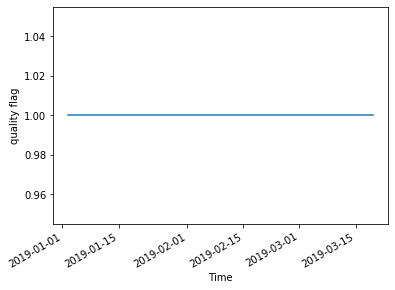

In [433]:
ds[param+'_QC'][:,0].plot()

Let's get only the good data for the only depth (0):

In [437]:
var = ds[param][:,0].values.tolist()

Let's set a colormap:

In [438]:
linear_cmap = branca.colormap.LinearColormap(['green', 'yellow', 'red'],vmin=min(var), vmax=max(var))
linear_cmap

Let's plot the temperature values along the trajectory:

In [452]:
m = folium.Map(location=[mean_lat, mean_lon], zoom_start=8)
for k in range(0,len(times)-1):
    try:
        color = linear_cmap(var[k])
        folium.CircleMarker([lats[k],lons[k]], radius=1,color=color).add_to(m)
    except Exception as e:
        pass
m.fit_bounds(m.get_bounds())
colormap = branca.colormap.LinearColormap(['green', 'yellow', 'red']).scale(int(min(var)), int(max(var))).to_step(6)
colormap.caption = 'Temperature variation along the vessel track'
m.add_child(colormap)
m

<div class="alert alert-block alert-warning">
<b>WARNING</b>
    
***  
If you do not see any map when running the next cell please change your navigator (try chrome!).

### Overall variable evolution

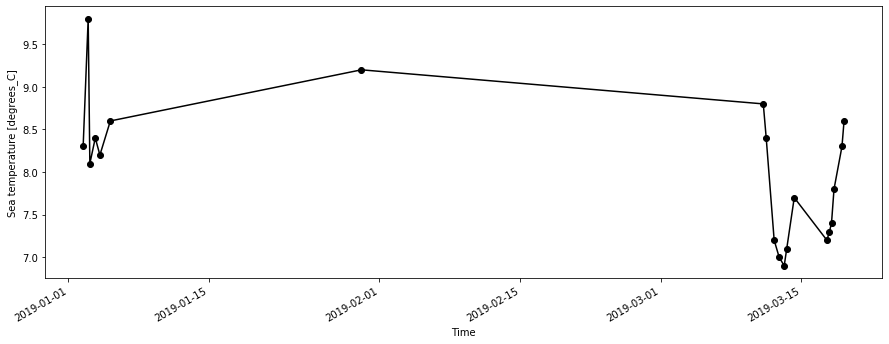

In [441]:
ds[param].plot(aspect=3, size=5, marker='o', color='k')

***

## Wrap-up

So far you should already know how to deal with trajectory-like Time Serie data from drifting buoys. <br> `If you don't please ask us! it is the moment!`

---



## Feedback survey

<div class="alert alert-block alert-success">
    <b>CONGRATULATIONS</b><br>

***
**IF IT'S 202025 PAST MIDDAY, PLEASE READ CAREFULLY BELOW LINES (ACTION FROM YOUR SIDE)**
***    
This training course is over but we'd love to hear from you about how we could improve it (topics, tools, storytelling, format, speed etc). 

We have prepared a little questionnaire to gather all your inputs, available here (just click on the hyperlink or execute the very last cell and click on `Answer`):
- https://tiny.cc/training-blk-insitu

We do thank you in advance for your kind collaboration :)

Greetings <3

In [ ]:
IPython.display.IFrame('https://tiny.cc/tw-blk-insitu', width=900, height=500)